# Understanding Dyna-Q: Integrating Learning and Planning

# Table of Contents

- [Introduction: Model-Based Reinforcement Learning](#introduction)
- [What is Dyna-Q?](#what-is-dyna-q)
  - [Direct RL vs. Planning](#direct-rl-vs-planning)
  - [The Dyna Architecture](#the-dyna-architecture)
- [Why Dyna-Q? The Value of a Model](#why-dyna-q)
- [Where and How Dyna-Q is Used](#where-and-how-dyna-q-is-used)
- [Mathematical Foundation of Dyna-Q](#mathematical-foundation-of-dyna-q)
  - [Q-Learning Recap (Direct RL Component)](#q-learning-recap)
  - [Model Learning (Tabular Case)](#model-learning-tabular-case)
  - [Planning (Simulated Experience Update)](#planning-simulated-experience-update)
- [Step-by-Step Explanation of Dyna-Q](#step-by-step-explanation-of-dyna-q)
- [Key Components of Dyna-Q](#key-components-of-dyna-q)
  - [Action-Value Function (Q-Table)](#action-value-function-q-table)
  - [Environment Model (Learned)](#environment-model-learned)
  - [Direct Reinforcement Learning Update](#direct-reinforcement-learning-update)
  - [Planning Updates (Model-Based)](#planning-updates-model-based)
  - [Exploration vs. Exploitation](#exploration-vs-exploitation)
  - [Number of Planning Steps (k)](#number-of-planning-steps-k)
  - [Hyperparameters](#hyperparameters)
- [Practical Example: Custom Grid World](#practical-example-custom-grid-world)
  - [Why Grid World for Dyna-Q?](#why-grid-world)
- [Setting up the Environment](#setting-up-the-environment)
- [Creating the Custom Environment](#creating-the-custom-environment)
- [Implementing the Dyna-Q Algorithm](#implementing-the-dyna-q-algorithm)
  - [Representing the Q-Table and Model](#representing-the-q-table-and-model)
  - [Action Selection (Epsilon-Greedy)](#action-selection-epsilon-greedy)
  - [Direct RL Update (Q-Learning)](#direct-rl-update-q-learning)
  - [Model Update](#model-update)
  - [Planning Step Function](#planning-step-function)
  - [Dyna-Q Agent Class (Optional Structure)](#dyna-q-agent-class-optional-structure)
- [Running the Dyna-Q Algorithm](#running-the-dyna-q-algorithm)
  - [Hyperparameter Setup](#hyperparameter-setup)
  - [Initialization](#initialization)
  - [Training Loop](#training-loop)
- [Visualizing the Learning Process](#visualizing-the-learning-process)
- [Analyzing the Learned Policy and Model (Optional Visualization)](#analyzing-the-learned-policy-and-model-optional-visualization)
- [Common Challenges and Extensions of Dyna-Q](#common-challenges-and-extensions-of-dyna-q)
- [Conclusion](#conclusion)

## Introduction: Model-Based Reinforcement Learning

Reinforcement Learning algorithms can be broadly categorized into **model-free** and **model-based** approaches.

- **Model-Free RL:** Algorithms like Q-Learning, DQN, REINFORCE, A2C, PPO learn directly from interaction with the environment through trial and error. They learn a value function or a policy without explicitly building a representation of the environment's dynamics (transitions and rewards).
- **Model-Based RL:** Algorithms learn a *model* of the environment (approximating the transition function $P(s'|s,a)$ and reward function $R(s,a,s')$) based on experience. This learned model can then be used for *planning* – simulating interactions within the model to improve the value function or policy without requiring additional real-world interaction.

Dyna-Q is a classic example that integrates model-free learning with model-based planning.

## What is Dyna-Q?

Dyna-Q, introduced by Richard Sutton, is an architecture that combines **Direct Reinforcement Learning** (learning from real experience) with **Planning** (learning from simulated experience generated by a learned model). It operates by interleaving steps of acting in the real world, learning from that real experience (both updating values/policy and updating the model), and then performing multiple planning steps using the learned model.

### Direct RL vs. Planning
- **Direct RL:** The agent takes an action $a_t$ in the real environment state $s_t$, observes the next state $s_{t+1}$ and reward $r_t$. This real transition $(s_t, a_t, r_t, s_{t+1})$ is used to update the agent's value function (e.g., Q-table) using a standard model-free algorithm like Q-Learning.
- **Model Learning:** The same real transition $(s_t, a_t, r_t, s_{t+1})$ is also used to update the agent's internal model of the environment. In the tabular case, this often means storing the observed outcome: Model $(s_t, a_t) \rightarrow (r_t, s_{t+1})$.
- **Planning:** The agent performs $k$ additional updates using *simulated* experiences. In each planning step, it:
    1.  Randomly samples a state $s$ and action $a$ that it has *previously experienced*.
    2.  Consults its learned model to predict the resulting reward $r$ and next state $s'$: $(r, s') = 	ext{Model}(s, a)$.
    3.  Applies the same Direct RL update rule (e.g., Q-Learning) to the value function using this simulated transition $(s, a, r, s')$.

### The Dyna Architecture
The name "Dyna" reflects this dynamic interplay: real experience improves the model and the value function/policy directly, while the model allows for planning steps that further improve the value function/policy indirectly through simulation.

## Why Dyna-Q? The Value of a Model

Model-based approaches like Dyna-Q offer significant advantages, primarily in **sample efficiency**:

1.  **Data Efficiency:** Real-world interactions can be expensive or slow. By learning a model, the agent can generate many simulated transitions from a single real transition. These simulated experiences allow for many more updates to the value function or policy than would be possible with only direct RL, leading to faster learning from fewer real-world interactions.
2.  **Focused Updates:** Planning steps can potentially focus updates on important parts of the state-action space or propagate value information more quickly through simulated trajectories.
3.  **Adaptability:** If the environment changes, the model can potentially be updated, allowing the planning process to quickly adapt the policy (though basic Dyna-Q addresses this more simply with Dyna-Q+).

The main cost is the need to learn and store the model, and the computational expense of the planning steps. The quality of the learned policy also depends on the accuracy of the learned model.

## Where and How Dyna-Q is Used

Dyna-Q is foundational and particularly illustrative in:

1.  **Tabular RL Problems:** Environments with discrete states and actions where Q-tables and simple models can be learned effectively (e.g., grid worlds, simple mazes).
2.  **Scenarios Requiring High Sample Efficiency:** When real environment interaction is costly.
3.  **Educational Purposes:** Clearly demonstrates the concept of integrating model learning and planning.

While the basic Dyna-Q uses tabular Q-learning and a simple deterministic model, the Dyna architecture can be extended:
- Using function approximation (neural networks) for the value function/policy and the model (e.g., Dyna-DQN).
- Learning probabilistic models.
- Using more sophisticated planning algorithms (e.g., Monte Carlo Tree Search) with the learned model.

## Mathematical Foundation of Dyna-Q

Dyna-Q primarily relies on the mathematics of its underlying components: Q-learning for direct RL and model updates, and the Q-learning update rule applied during planning.

### Q-Learning Recap (Direct RL Component)
The agent maintains an action-value function $Q(s, a)$, representing the expected return starting from state $s$, taking action $a$, and following the current policy thereafter. For a *real* transition $(s_t, a_t, r_t, s_{t+1})$, the Q-value is updated using the TD error:
$$ Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left[ r_t + \gamma \max_{a'} Q(s_{t+1}, a') - Q(s_t, a_t) \right] $$
where $\alpha$ is the learning rate and $\gamma$ is the discount factor.

### Model Learning (Tabular Case)
The model $Model(s, a)$ stores the observed outcome of taking action $a$ in state $s$. For a deterministic environment, after observing $(s_t, a_t, r_t, s_{t+1})$, the model is updated:
$$ Model(s_t, a_t) \leftarrow (r_t, s_{t+1}) $$
This is typically stored in a dictionary or hash map where the key is the `(state, action)` pair.

### Planning (Simulated Experience Update)
During each planning step, the agent:
1.  Selects a state-action pair $(s_p, a_p)$ that has been previously observed (i.e., exists in the `Model`).
2.  Retrieves the simulated outcome from the model: $(r_p, s'_p) = Model(s_p, a_p)$.
3.  Applies the Q-learning update using this *simulated* transition:
    $$ Q(s_p, a_p) \leftarrow Q(s_p, a_p) + \alpha \left[ r_p + \gamma \max_{a'} Q(s'_p, a') - Q(s_p, a_p) \right] $$
This allows propagating value information based on the learned model without interacting with the real environment.

## Step-by-Step Explanation of Dyna-Q

1.  **Initialize**: Q-table $Q(s, a)$ (e.g., to zeros), Model $Model(s, a)$ (empty). Hyperparameters $\alpha, \gamma, \epsilon$, planning steps $k$.
2.  **Loop for each episode**:
    a.  Get initial state $s$ from environment.
    b.  **Loop for each step of episode**:
        i.   Choose action $a$ from state $s$ using policy based on $Q$ (e.g., $\epsilon$-greedy).
        ii.  Take action $a$, observe real reward $r$ and next state $s'$.
        iii. **Direct RL Update**: Update $Q(s, a)$ using the real transition $(s, a, r, s')$ via Q-learning rule.
        iv.  **Model Update**: Store the observed transition: $Model(s, a) \leftarrow (r, s')$. Add $(s,a)$ to list of observed pairs if needed for sampling.
        v.   **Planning**: Repeat $k$ times:
            1.  Randomly sample a state $s_p$ and action $a_p$ from *previously observed* pairs.
            2.  Get simulated outcome $(r_p, s'_p) = Model(s_p, a_p)$.
            3.  Apply Q-learning update to $Q(s_p, a_p)$ using $(s_p, a_p, r_p, s'_p)$.
        vi.  Update state: $s \leftarrow s'$.
        vii. If $s'$ is terminal, break episode step loop.
3.  **Repeat**: Until convergence or max episodes.

## Key Components of Dyna-Q

### Action-Value Function (Q-Table)
- Stores the estimated value of taking each action in each state.
- Typically a dictionary or multi-dimensional array in the tabular case.
- Updated by both Direct RL and Planning steps.

### Environment Model (Learned)
- Stores the learned dynamics (transitions and rewards).
- In tabular Dyna-Q, often a dictionary mapping `(state, action)` tuples to `(reward, next_state)` tuples.
- Updated only from *real* environment interactions.

### Direct Reinforcement Learning Update
- Updates the Q-table based on actual transitions experienced in the environment (e.g., Q-learning).

### Planning Updates (Model-Based)
- Updates the Q-table based on simulated transitions generated by querying the learned model.
- Performed $k$ times after each real step.

### Exploration vs. Exploitation
- Handled by the policy derived from the Q-table during *real* interaction (e.g., $\epsilon$-greedy).
- Planning steps typically use the learned Q-values directly for updates (exploiting the current value estimates within the model).

### Number of Planning Steps (k)
- A crucial hyperparameter controlling the amount of planning relative to direct interaction. $k=0$ recovers model-free Q-learning. Larger $k$ increases computational cost but can significantly speed up learning if the model is accurate.

### Hyperparameters
- Learning rate ($\alpha$), discount factor ($\gamma$), exploration rate ($\epsilon$).
- Number of planning steps ($k$).

## Practical Example: Custom Grid World

### Why Grid World for Dyna-Q?
The Grid World is ideal for demonstrating Dyna-Q because:
1.  **Discrete States/Actions:** Fits the tabular representation of the Q-function and the model used in classic Dyna-Q.
2.  **Simplicity:** The dynamics are easy to understand and learn, allowing focus on the Dyna-Q mechanism itself.
3.  **Determinism (Optional):** A deterministic version allows the model to become perfectly accurate quickly, clearly showing the benefit of planning. We'll use the deterministic version here.
4.  **Visualization:** Q-values, the model, and the policy can be easily visualized.

**Environment Description:** (Same as before, using tuple states)
- Grid Size: 10x10.
- **State:** Agent's `(row, col)` tuple.
- Actions: 4 discrete (0: Up, 1: Down, 2: Left, 3: Right).
- Start: (0, 0), Goal: (9, 9).
- Rewards: +10 (goal), -1 (wall), -0.1 (step).
- Termination: Goal or max steps.


# Setting up the Environment

Import libraries. We only need basic Python data structures and `numpy`/`matplotlib`.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict # Useful for Q-table and model
from typing import Tuple, Dict, Any, List, DefaultDict

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)

%matplotlib inline

# Creating the Custom Environment

Using the `GridEnvironment` class, slightly modified to return state tuples directly, suitable for tabular methods.

In [2]:
class GridEnvironmentTabular:
    """
    Grid World returning state tuples, suitable for tabular methods.
    Rewards: +10 (goal), -1 (wall), -0.1 (step).
    """
    def __init__(self, rows: int = 10, cols: int = 10) -> None:
        self.rows: int = rows
        self.cols: int = cols
        self.start_state: Tuple[int, int] = (0, 0)
        self.goal_state: Tuple[int, int] = (rows - 1, cols - 1)
        self.state: Tuple[int, int] = self.start_state
        self.action_dim: int = 4
        self.action_map: Dict[int, Tuple[int, int]] = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}

    def reset(self) -> Tuple[int, int]:
        """ Resets environment, returns state tuple. """
        self.state = self.start_state
        return self.state

    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool]:
        """
        Performs one step, returns (next_state_tuple, reward, done).
        """
        if self.state == self.goal_state:
            return self.state, 0.0, True
        
        dr, dc = self.action_map[action]
        current_row, current_col = self.state
        next_row, next_col = current_row + dr, current_col + dc
        
        reward: float = -0.1
        if not (0 <= next_row < self.rows and 0 <= next_col < self.cols):
            next_row, next_col = current_row, current_col # Stay in place
            reward = -1.0
            
        self.state = (next_row, next_col)
        next_state_tuple = self.state
        
        done: bool = (self.state == self.goal_state)
        if done:
            reward = 10.0
            
        return next_state_tuple, reward, done

    def get_action_space_size(self) -> int:
        return self.action_dim

Instantiate and test the environment.

In [3]:
custom_env_tabular = GridEnvironmentTabular(rows=10, cols=10)
n_actions_tabular = custom_env_tabular.get_action_space_size()

print(f"Tabular Grid Environment:")
print(f"Size: {custom_env_tabular.rows}x{custom_env_tabular.cols}")
print(f"Action Dim: {n_actions_tabular}")
start_state_tuple = custom_env_tabular.reset()
print(f"Start State: {start_state_tuple}")
next_s, r, d = custom_env_tabular.step(3) # Move Right
print(f"Step result (action=Right): next_state={next_s}, reward={r}, done={d}")

Tabular Grid Environment:
Size: 10x10
Action Dim: 4
Start State: (0, 0)
Step result (action=Right): next_state=(0, 1), reward=-0.1, done=False


# Implementing the Dyna-Q Algorithm

We'll implement Dyna-Q using functions or optionally within an Agent class for structure.

### Representing the Q-Table and Model

`defaultdict` is convenient for Q-tables (returns 0 for unvisited state-actions) and the model.

In [4]:
# Initialize Q-table and Model
# Q-table maps (state_tuple, action) -> Q-value
Q_table: DefaultDict[Tuple[Tuple[int, int], int], float] = defaultdict(float)

# Model maps (state_tuple, action) -> (reward, next_state_tuple)
Model: Dict[Tuple[Tuple[int, int], int], Tuple[float, Tuple[int, int]]] = {}

# Keep track of observed state-action pairs for planning sampling
Observed_State_Actions: List[Tuple[Tuple[int, int], int]] = []

### Action Selection (Epsilon-Greedy)

Standard epsilon-greedy selection based on the Q-table.

In [5]:
def choose_action_epsilon_greedy(state: Tuple[int, int], 
                                 q_table: DefaultDict[Tuple[Tuple[int, int], int], float], 
                                 epsilon: float, 
                                 n_actions: int) -> int:
    """
    Chooses an action using epsilon-greedy policy based on the Q-table.
    
    Parameters:
    - state (Tuple[int, int]): The current state tuple.
    - q_table (DefaultDict): The current Q-value estimates.
    - epsilon (float): The probability of choosing a random action.
    - n_actions (int): The total number of possible actions.
    
    Returns:
    - int: The chosen action index.
    """
    if random.random() < epsilon:
        # Explore: choose a random action
        return random.randrange(n_actions)
    else:
        # Exploit: choose the best action based on Q-values
        q_values = [q_table[(state, a)] for a in range(n_actions)]
        max_q = max(q_values)
        # Handle ties by choosing randomly among best actions
        best_actions = [a for a, q in enumerate(q_values) if q == max_q]
        return random.choice(best_actions)

### Direct RL Update (Q-Learning)

Performs the Q-learning update on the Q-table.

In [6]:
def q_learning_update(q_table: DefaultDict[Tuple[Tuple[int, int], int], float],
                        state: Tuple[int, int],
                        action: int,
                        reward: float,
                        next_state: Tuple[int, int],
                        alpha: float,
                        gamma: float,
                        n_actions: int,
                        is_done: bool) -> None:
    """
    Performs a single Q-learning update step.
    
    Parameters:
    - q_table: The Q-table to update.
    - state, action, reward, next_state, is_done: Transition elements.
    - alpha: Learning rate.
    - gamma: Discount factor.
    - n_actions: Number of actions.
    """
    # Get current Q-value
    current_q = q_table[(state, action)]
    
    # Get max Q-value for the next state (target)
    if is_done:
        target_q = 0.0 # No future reward if episode is done
    else:
        next_q_values = [q_table[(next_state, a)] for a in range(n_actions)]
        max_next_q = max(next_q_values) if next_q_values else 0.0
        target_q = max_next_q
        
    # Calculate TD target and TD error
    td_target = reward + gamma * target_q
    td_error = td_target - current_q
    
    # Update Q-value
    new_q = current_q + alpha * td_error
    q_table[(state, action)] = new_q

### Model Update

Updates the learned model with the observed transition.

In [7]:
def update_model(model: Dict[Tuple[Tuple[int, int], int], Tuple[float, Tuple[int, int]]],
                 observed_pairs: List[Tuple[Tuple[int, int], int]],
                 state: Tuple[int, int],
                 action: int,
                 reward: float,
                 next_state: Tuple[int, int]) -> None:
    """
    Updates the deterministic tabular model.
    
    Parameters:
    - model: The model dictionary.
    - observed_pairs: List tracking observed (state, action) pairs.
    - state, action, reward, next_state: Transition elements.
    """
    state_action = (state, action)
    # Store the observed outcome
    model[state_action] = (reward, next_state)
    
    # Add to list of observed pairs if not already present (for planning sampling)
    # Using a set for efficient checking might be better for large state spaces,
    # but a list is simpler for this example.
    if state_action not in observed_pairs:
        observed_pairs.append(state_action)

### Planning Step Function

Performs `k` planning updates using the model.

In [8]:
def planning_steps(k: int,
                   q_table: DefaultDict[Tuple[Tuple[int, int], int], float],
                   model: Dict[Tuple[Tuple[int, int], int], Tuple[float, Tuple[int, int]]],
                   observed_pairs: List[Tuple[Tuple[int, int], int]],
                   alpha: float,
                   gamma: float,
                   n_actions: int) -> None:
    """
    Performs 'k' planning steps using the learned model.
    
    Parameters:
    - k: Number of planning steps.
    - q_table, model, observed_pairs: Agent's components.
    - alpha, gamma, n_actions: Hyperparameters.
    """
    if not observed_pairs: # Cannot plan if nothing has been observed
        return
        
    for _ in range(k):
        # Sample a random previously observed state-action pair
        state_p, action_p = random.choice(observed_pairs)
        
        # Get the simulated reward and next state from the model
        reward_p, next_state_p = model[(state_p, action_p)]
        
        # Perform Q-learning update using the simulated experience
        # Note: The simulated next state might not be terminal, so is_done is False
        # In more complex models/environments, the model might also predict termination.
        q_learning_update(q_table, state_p, action_p, reward_p, next_state_p,
                          alpha, gamma, n_actions, is_done=False) 

### Dyna-Q Agent Class (Optional Structure)

We can group these components into a class for better organization, mirroring the structure used for network-based agents.

In [9]:
class DynaQAgent:
    """ Encapsulates the Dyna-Q algorithm components and logic. """
    def __init__(self, n_actions: int, 
                 alpha: float, gamma: float, epsilon: float, 
                 planning_steps: int):
        self.n_actions: int = n_actions
        self.alpha: float = alpha
        self.gamma: float = gamma
        self.epsilon: float = epsilon
        self.k: int = planning_steps
        
        self.q_table: DefaultDict[Tuple[Tuple[int, int], int], float] = defaultdict(float)
        self.model: Dict[Tuple[Tuple[int, int], int], Tuple[float, Tuple[int, int]]] = {}
        self.observed_pairs: List[Tuple[Tuple[int, int], int]] = []

    def choose_action(self, state: Tuple[int, int]) -> int:
        """ Choose action using epsilon-greedy. """
        return choose_action_epsilon_greedy(state, self.q_table, self.epsilon, self.n_actions)

    def learn(self, state: Tuple[int, int], action: int, reward: float, 
              next_state: Tuple[int, int], done: bool) -> None:
        """
        Perform Direct RL update, Model update, and Planning steps.
        """
        # Direct RL Update
        q_learning_update(self.q_table, state, action, reward, next_state, 
                          self.alpha, self.gamma, self.n_actions, done)
        
        # Model Update
        update_model(self.model, self.observed_pairs, state, action, reward, next_state)
        
        # Planning
        planning_steps(self.k, self.q_table, self.model, self.observed_pairs, 
                       self.alpha, self.gamma, self.n_actions)
                       
    def update_epsilon(self, new_epsilon: float) -> None:
        """ Update the exploration rate. """
        self.epsilon = new_epsilon

# Running the Dyna-Q Algorithm

Set up hyperparameters, initialize the agent, and run the training loop.

### Hyperparameter Setup

Define Dyna-Q hyperparameters.

In [10]:
# Hyperparameters for Dyna-Q on Custom Grid World
ALPHA = 0.1                 # Learning rate
GAMMA = 0.95                # Discount factor
EPSILON_START = 1.0         # Initial exploration rate
EPSILON_END = 0.01          # Final exploration rate
EPSILON_DECAY = 0.995       # Epsilon decay factor per episode
PLANNING_STEPS_K = 50       # Number of planning steps (k)

NUM_EPISODES_DYNAQ = 500    # Number of training episodes
MAX_STEPS_PER_EPISODE_DYNAQ = 200 # Max steps per episode

### Initialization

Initialize the environment and the Dyna-Q agent.

In [11]:
# Instantiate the environment
env_dynaq = GridEnvironmentTabular(rows=10, cols=10)
n_actions = env_dynaq.get_action_space_size()

# Initialize the Dyna-Q Agent
agent = DynaQAgent(n_actions=n_actions,
                   alpha=ALPHA,
                   gamma=GAMMA,
                   epsilon=EPSILON_START,
                   planning_steps=PLANNING_STEPS_K)

# Lists for plotting
dynaq_episode_rewards = []
dynaq_episode_lengths = []
dynaq_episode_epsilons = []

### Training Loop

The Dyna-Q training loop interleaves acting, learning, and planning.

In [12]:
print(f"Starting Dyna-Q Training (k={PLANNING_STEPS_K})...")

# --- Dyna-Q Training Loop ---
current_epsilon = EPSILON_START

for i_episode in range(1, NUM_EPISODES_DYNAQ + 1):
    state: Tuple[int, int] = env_dynaq.reset()
    episode_reward: float = 0.0
    
    agent.update_epsilon(current_epsilon) # Set current epsilon for the agent
    
    for t in range(MAX_STEPS_PER_EPISODE_DYNAQ):
        # Choose action
        action: int = agent.choose_action(state)
        
        # Interact with environment
        next_state, reward, done = env_dynaq.step(action)
        
        # Learn (Direct RL, Model Update, Planning)
        agent.learn(state, action, reward, next_state, done)
        
        state = next_state
        episode_reward += reward
        
        if done:
            break
            
    # --- End of Episode --- 
    dynaq_episode_rewards.append(episode_reward)
    dynaq_episode_lengths.append(t + 1)
    dynaq_episode_epsilons.append(current_epsilon)
    
    # Decay epsilon
    current_epsilon = max(EPSILON_END, current_epsilon * EPSILON_DECAY)
    
    # Print progress
    if i_episode % 50 == 0:
        avg_reward = np.mean(dynaq_episode_rewards[-50:])
        avg_length = np.mean(dynaq_episode_lengths[-50:])
        print(f"Episode {i_episode}/{NUM_EPISODES_DYNAQ} | Avg Reward (last 50): {avg_reward:.2f} | Avg Length: {avg_length:.1f} | Epsilon: {current_epsilon:.3f}")

print("Grid World Training Finished (Dyna-Q).")

Starting Dyna-Q Training (k=50)...
Episode 50/500 | Avg Reward (last 50): -15.37 | Avg Length: 130.0 | Epsilon: 0.778
Episode 100/500 | Avg Reward (last 50): 1.82 | Avg Length: 51.7 | Epsilon: 0.606
Episode 150/500 | Avg Reward (last 50): 4.09 | Avg Length: 38.3 | Epsilon: 0.471
Episode 200/500 | Avg Reward (last 50): 5.81 | Avg Length: 31.9 | Epsilon: 0.367
Episode 250/500 | Avg Reward (last 50): 6.50 | Avg Length: 28.1 | Epsilon: 0.286
Episode 300/500 | Avg Reward (last 50): 7.26 | Avg Length: 23.2 | Epsilon: 0.222
Episode 350/500 | Avg Reward (last 50): 7.53 | Avg Length: 22.1 | Epsilon: 0.173
Episode 400/500 | Avg Reward (last 50): 7.63 | Avg Length: 20.9 | Epsilon: 0.135
Episode 450/500 | Avg Reward (last 50): 7.75 | Avg Length: 20.2 | Epsilon: 0.105
Episode 500/500 | Avg Reward (last 50): 7.89 | Avg Length: 19.7 | Epsilon: 0.082
Grid World Training Finished (Dyna-Q).


# Visualizing the Learning Process

Plot episode rewards, lengths, and epsilon decay.

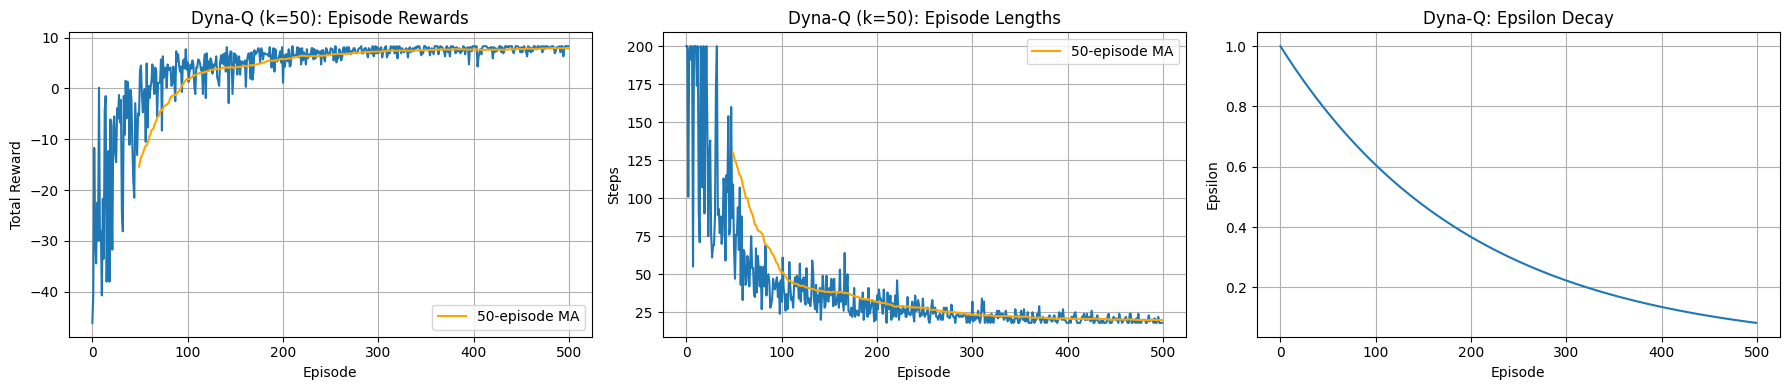

In [13]:
# Plotting results for Dyna-Q on Custom Grid World
plt.figure(figsize=(18, 4))

# Rewards
plt.subplot(1, 3, 1)
plt.plot(dynaq_episode_rewards)
plt.title(f'Dyna-Q (k={PLANNING_STEPS_K}): Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
if len(dynaq_episode_rewards) >= 50:
    rewards_ma_dynaq = np.convolve(dynaq_episode_rewards, np.ones(50)/50, mode='valid')
    plt.plot(np.arange(len(rewards_ma_dynaq)) + 49, rewards_ma_dynaq, label='50-episode MA', color='orange')
    plt.legend()

# Lengths
plt.subplot(1, 3, 2)
plt.plot(dynaq_episode_lengths)
plt.title(f'Dyna-Q (k={PLANNING_STEPS_K}): Episode Lengths')
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.grid(True)
if len(dynaq_episode_lengths) >= 50:
    lengths_ma_dynaq = np.convolve(dynaq_episode_lengths, np.ones(50)/50, mode='valid')
    plt.plot(np.arange(len(lengths_ma_dynaq)) + 49, lengths_ma_dynaq, label='50-episode MA', color='orange')
    plt.legend()

# Epsilon
plt.subplot(1, 3, 3)
plt.plot(dynaq_episode_epsilons)
plt.title('Dyna-Q: Epsilon Decay')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.grid(True)

plt.tight_layout()
plt.show()

**Analysis of Dyna-Q (k=50) Learning Curves (Custom Grid World):**

1.  **Episode Rewards:**
    The agent learns effectively, with the moving average (orange line) showing a steady and significant increase in rewards, particularly between episodes ~50 and 200, before plateauing near the optimal value (around 8). The raw rewards (blue line) exhibit moderate variance during learning but stabilize considerably once the optimal policy is found, indicating successful convergence.

2.  **Episode Lengths:**
    Correspondingly, the average episode length decreases substantially over time. The moving average shows a clear downward trend, converging towards the optimal path length (~18 steps) by around episode 300. The raw lengths are initially very noisy but become much more consistent as the agent learns and exploration (epsilon) decreases.

3.  **Epsilon Decay:**
    The epsilon value, controlling the exploration rate (probability of choosing a random action), decays exponentially from 1.0 towards a low value (near 0.05) over the 500 episodes. This planned reduction in exploration allows the agent to initially explore the environment broadly and then increasingly exploit its learned knowledge (the Q-values updated by both real and model-simulated experience). The decay rate seems well-matched to the learning progress observed in the other plots.

**Overall Conclusion:**
Dyna-Q (with k=50 planning steps) successfully solved the Grid World task, demonstrating efficient learning by combining direct reinforcement learning with model-based planning. The agent learned both a high-reward and an efficient path policy, converging stably. The effectiveness is aided by the planned exploration decay and the additional updates derived from the learned world model, potentially leading to faster convergence than purely model-free methods like basic Q-learning in some scenarios.

# Analyzing the Learned Policy and Model (Optional Visualization)

Visualize the final policy derived from the learned Q-table.


Plotting Learned Policy from Dyna-Q:


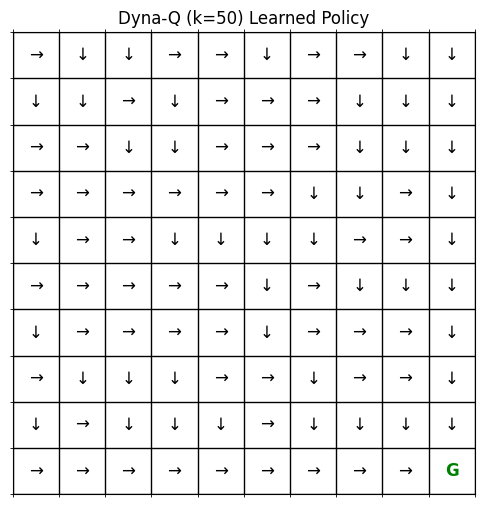

In [14]:
def plot_tabular_policy_grid(q_table: DefaultDict[Tuple[Tuple[int, int], int], float], 
                             env: GridEnvironmentTabular) -> None:
    """
    Plots the greedy policy derived from a tabular Q-table.
    """
    rows: int = env.rows
    cols: int = env.cols
    policy_grid: np.ndarray = np.empty((rows, cols), dtype=str)
    action_symbols: Dict[int, str] = {0: '↑', 1: '↓', 2: '←', 3: '→'} 

    fig, ax = plt.subplots(figsize=(cols * 0.6, rows * 0.6))

    for r in range(rows):
        for c in range(cols):
            state_tuple: Tuple[int, int] = (r, c)
            if state_tuple == env.goal_state:
                policy_grid[r, c] = 'G'
                ax.text(c, r, 'G', ha='center', va='center', color='green', fontsize=12, weight='bold')
            else:
                q_values = [q_table[(state_tuple, a)] for a in range(env.get_action_space_size())]
                if not q_values or all(q == 0 for q in q_values): # If state not visited or all Q=0
                    best_action = -1 # Indicate no learned action yet
                    symbol = '.'
                else:
                    max_q = max(q_values)
                    best_actions = [a for a, q in enumerate(q_values) if q == max_q]
                    best_action = random.choice(best_actions) # Break ties randomly
                    symbol = action_symbols[best_action]
                
                policy_grid[r, c] = symbol
                ax.text(c, r, symbol, ha='center', va='center', color='black', fontsize=12)

    ax.matshow(np.zeros((rows, cols)), cmap='Greys', alpha=0.1)
    ax.set_xticks(np.arange(-.5, cols, 1), minor=True)
    ax.set_yticks(np.arange(-.5, rows, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Dyna-Q (k={PLANNING_STEPS_K}) Learned Policy")
    plt.show()

# Plot the final policy
print("\nPlotting Learned Policy from Dyna-Q:")
plot_tabular_policy_grid(agent.q_table, env_dynaq)

## Common Challenges and Extensions of Dyna-Q

**Challenge: Model Accuracy**
*   **Problem:** The effectiveness of planning depends entirely on the accuracy of the learned model. If the model is poor (especially in stochastic or complex environments), planning with it can reinforce incorrect dynamics and lead to suboptimal policies.
*   **Solutions**:
    *   **Sufficient Exploration:** Ensure the agent explores enough to experience diverse transitions for model learning.
    *   **Model Uncertainty:** More advanced methods track uncertainty in the model and adjust planning accordingly.
    *   **Probabilistic Models:** Learn a distribution $P(s', r | s, a)$ instead of just one outcome.
    * **Limit Planning:** Reduce $k$ if the model is suspected to be inaccurate.

**Challenge: Computational Cost of Planning**
*   **Problem:** Performing $k$ updates per real step can become computationally expensive, especially if $k$ is large or the state space is huge.
*   **Solutions**:
    *   **Optimize $k$:** Choose a moderate value for $k$.
    *   **Prioritized Sweeping:** An extension where planning steps are focused on states whose values are likely to change the most (e.g., predecessors of states whose value just changed significantly), rather than purely random sampling.

**Challenge: Scalability (Tabular Limitation)**
*   **Problem:** Basic tabular Dyna-Q doesn't scale to large or continuous state/action spaces.
*   **Solutions**:
    *   **Function Approximation:** Use neural networks for the Q-function (or policy) and potentially for the model (e.g., learning a dynamics network $s_{t+1} = f(s_t, a_t)$). This leads to Dyna-style algorithms with function approximation (e.g., Dyna-DQN, World Models).

**Challenge: Deterministic Model Limitation**
*   **Problem:** The simple model `Model(s, a) -> (r, s')` assumes deterministic transitions. It only stores the *last* observed outcome.
*   **Solutions**:
    *   **Learn Frequencies/Probabilities:** Store counts or estimate probabilities $P(s', r | s, a)$ for stochastic environments.
    *   **More Complex Models:** Use Gaussian processes or neural networks capable of representing distributions.

**Extension: Dyna-Q+**
*   Addresses environments where dynamics might change. It adds an "exploration bonus" to encourage trying actions in states that haven't been visited recently, potentially discovering changes in the environment dynamics more quickly.

## Conclusion

Dyna-Q provides a clear and effective framework for integrating model-free learning with model-based planning. By learning a model of the environment from real interactions and using it to generate simulated experiences for additional updates, it can significantly improve sample efficiency compared to purely model-free methods like Q-learning ($k=0$).

Its core strength lies in leveraging each real experience multiple times—once for direct learning and model improvement, and potentially many times via simulated planning steps. While the basic tabular implementation has limitations in scalability and handling stochasticity, the underlying Dyna architecture is a powerful concept that forms the basis for many advanced model-based reinforcement learning algorithms that utilize function approximation and more sophisticated planning techniques.